### Loading packages

In [1]:
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import time
import warnings
import os

In [2]:
# set seed to control sources of randomness for reproducibilty
np.random.seed(1);   
torch.manual_seed(1);

### Discretized example problem

In [3]:
import OCP

# name problem
problem_type = 'HighDimHyperbolicRxnBilinCtrl'

# choose dimension
n = 40

# choose reaction term
#rxn = None
rxn = 'hyperbolic'
#rxn = 'logistic'

# choose control term
#ctrl=None
#ctrl = 'add'
ctrl = 'bilin'

# choose indicator function for additive control
#ind_fun = (0.25, 0.5)
#ind_fun = (0.25, 0.75)

# choose target
#target = OCP.zero
target = OCP.quadratic
#target = OCP.polynomial
#target = OCP.sin   
#target = OCP.quadratic_cos

# choose coefficients for system and cost
system_coeff = {'a':0.02, 'b':1., 'c':1.}
cost_coeff = {'alpha':1., 'beta':0.1, 'gamma':2.}

# choose initial and final time, 1D space and initial condition domain
#t=(0.,5.)
#Omega=(0.,1.)
#X0=(-1.5,1.5))

# initialize problem
problem = OCP.ControlledReactionDiffusionSystem(n, rxn=rxn, ctrl=ctrl, target=target, 
                                                system_coeff=system_coeff, cost_coeff=cost_coeff)

# save problem and its configurations
problem.save_config(problem_type)
problem.save_problem(problem_type)

### Initial data generation

In [4]:
import BVP
import data_generation

# choose number of trajectories in initial training set and validation set
num_train_samples = 5 
num_val_samples = 5

# choose time-marching sequence
init_config = {'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}

# generate initial training data using time-marching
X0_samples = data_generation.sample_X0(problem, num_samples=num_train_samples)
print('------------------------------------\n Initial Training Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                                                       init_config=init_config)
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'train')

# generate validation data using time-marching
X0_samples = data_generation.sample_X0(problem, num_samples=num_val_samples)
print('------------------------------------\n Validation Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                                                       init_config=init_config)
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'val')

------------------------------------
 Initial Training Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 5 generating 1691 data points (from 1512 initially guessed points)
solution time:       74.689965 of which 16.785320 solving BVP
solution time per data point: 0.044169

------------------------------------
 Validation Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 5 generating 1738 data points (from 1524 initially guessed points)
solution time:       74.944925 of which 17.336617 solving BVP
solution time per data point: 0.043121



### Neural network model

In [5]:
import NN

# name model
model_type = 'ResidualForcedFinalConditionNet'

# set hyperparameters
depth = 4
width = 100

#activation = nn.Tanh()        
#activation = nn.ReLU()         
activation = nn.Softplus()

#architecture = 'feedforward'  
architecture = 'residual'

# get cpu or gpu device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'using {device} device\n')

# initialize model
#model = NN.FeedforwardNet(n, depth, width, activation, device).to(device)
model = NN.NeuralNet(n, depth, width, activation, architecture, device).to(device)
model = NN.ForcedFinalConditionNet(model, problem)

# print model and its parameters
print('------------------------------------\n Neural Network Model\n------------------------------------')
print(model)

using cpu device

------------------------------------
 Neural Network Model
------------------------------------
ForcedFinalConditionNet(
  (model): NeuralNet(
    (activation): Softplus(beta=1, threshold=20)
    (input_layer): Linear(in_features=41, out_features=100, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Linear(in_features=100, out_features=100, bias=True)
    )
    (output_layer): Linear(in_features=100, out_features=1, bias=True)
  )
  (activation): Softplus(beta=1, threshold=20)
)


### Training with adaptive data generation

In [6]:
import NN_optimization

# name training
train_type = 'Adam'

# initialize optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
#optimizer = torch.optim.LBFGS(model.parameters())

# choose batch size
batch_size = 100
#batch_size = 'full'

# choose gradient regularization weight
#grad_reg = 0.
grad_reg = 100.

# choose early stopping, data set size selection and convergence parameters
#criterion = 'GL' 
criterion = 'PQ'
#criterion = 'UP'
error_metric = [0., 0., 1.]
#error_metric = [1., grad_reg, 0.]
stop_params = {'error_metric':error_metric, 'strip':5, 'num_strips':1, 
               'max_iter':50, 'min_progress':0.01, 'criterion':criterion, 'stop_tol':0.1}
select_params = {'subset_size':None, 'conv_tol':4e-4, 'growth_ub':1.25}
max_epoch = 200
max_time = 1000.

# save partially trained models
#partial_train_times = [float('inf')]
partial_train_times = [5, 100, float('inf')] 
current_train_phase = 0
partial_train_type = train_type + 'PartialTrain' + str(partial_train_times[current_train_phase])

# initialize training and convergence
training = NN_optimization.NetTraining(optimizer, batch_size, grad_reg=grad_reg, 
                                       max_epoch=max_epoch, max_time=max_time,
                                       stop_params=stop_params, select_params=select_params)

# save model configurations
model.save_config(problem_type, model_type, train_type)

# save training configurations
training.save_config(problem_type, model_type, train_type)

In [7]:
start_train_time = time.time()

# loop for convergence test and data generation
while True:
    # create data set
    train_data = data_generation.OCPDataset(problem_type, 'train')
    val_data = data_generation.OCPDataset(problem_type, 'val')

    # create dataloader
    if training.batch_size == 'full':
        train_dataloader = DataLoader(train_data, batch_size=len(train_data))
        val_dataloader = DataLoader(val_data, batch_size=len(val_data))    
    else:
        train_dataloader = DataLoader(train_data, batch_size=training.batch_size, shuffle=True)
        val_dataloader = DataLoader(val_data, batch_size=training.batch_size, shuffle=True)

    # loop for training with fixed data set
    while True:
        training.current_epoch += 1
        print(f'------------------------------------\n Epoch {training.current_epoch}\n------------------------------------')
        
        # track number of training data
        num_train_data = len(train_data)
        training.num_train_data.append(num_train_data)
        
        # train model
        training.train(train_dataloader, model)
        print('')
        
        # compute relative errors
        print('training errors:')
        training.train_errors = np.hstack((training.train_errors, training.validate(train_dataloader, problem, model)))
        print('validation errors:')
        training.val_errors = np.hstack((training.val_errors, training.validate(val_dataloader, problem, model)))
        print('')
        
        # update optimal epoch and check early stopping criterion to prevent overfitting
        stop = training.early_stop()
        print('')
        
        # save model parameters of optimal epoch
        if training.opt_epoch == training.current_epoch:
            model.save_model(problem_type, model_type, train_type) 
        
        # track training time
        end_train_time = time.time()
        training.train_times.append(end_train_time - start_train_time)
        start_train_time = time.time()
        
        # save partially trained model
        if sum(training.train_times) >= partial_train_times[current_train_phase]:
            partial_train_model = NN.load_model(problem_type, model_type, train_type)
            partial_train_model.save_model(problem_type, model_type, partial_train_type) 
            current_train_phase += 1
            partial_train_type = train_type + 'PartialTrain' + str(partial_train_times[current_train_phase])
        
        # stop iterations
        if stop or training.current_epoch >= training.max_epoch or sum(training.train_times) >= training.max_time:
            training.stop_epochs.append(training.current_epoch)
            break
    
    if training.current_epoch >= training.max_epoch:
        print('Training terminated: maximum number of epochs is exceeded')
        break
        
    if sum(training.train_times) >= training.max_time:
        print('Training terminated: maximum time limit is exceeded')
        break
    
    # compute adaptive subset size for approximation of convergence criterion
    training.select_params['subset_size'] = int(100 * np.log(num_train_data/100 + 1))
    
    # select data set size
    new_num_train_data = training.select_dataset_size(train_data, model)
    training.generation_ratios.append(new_num_train_data/num_train_data)
    
    if new_num_train_data == num_train_data:
        print('Training terminated: convergence criterion is satisfied')
        break

    # generate data adaptively
    print('------------------------------------\n Adaptive Data Generation\n------------------------------------')
    # reset Adam
    #training.optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0.01)
    while new_num_train_data > num_train_data and (sum(training.train_times) + time.time() - start_train_time) < training.max_time:
        # sample and select initial conditions with largest gradient norm
        X0_candidates = data_generation.sample_X0(problem, num_samples=10)
        X0_sample = data_generation.select_X0(problem, model, X0_candidates, num_top=1)
        
        # solve BVP with NN warm start
        solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
        t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_sample, initialization='NN_warm_start', 
                                                           init_config={'model':model}, solver_config=solver_config)
        # track number of generated data
        num_train_data += len(t_data)
        print(f'data generated: {num_train_data} / {new_num_train_data} \n')
        
        # add new data to saved data
        data_generation.update_data(t_data, X_aug_data, idx_samples, problem_type, 'train')
    
    if (sum(training.train_times) + time.time() - start_train_time) >= max_time:
        print('Training terminated: maximum time limit is exceeded')
        break

end_train_time = time.time()
training.train_times.append(end_train_time - start_train_time)
        
# save training instance
training.save_training(problem_type, model_type, train_type)

------------------------------------
 Epoch 1
------------------------------------
total loss: 10.024926, value loss: 3.588599, grad loss: 0.064363 [    0/ 1691]
total loss: 8.643468, value loss: 1.188687, grad loss: 0.074548 [ 1000/ 1691]

training errors:
value RMAE: 0.461793, grad RML1: 0.480833, ctrl RMAE: 3.362528
validation errors:
value RMAE: 1.933685, grad RML1: 0.646073, ctrl RMAE: 2.598082

generalization loss: 0.000000

------------------------------------
 Epoch 2
------------------------------------
total loss: 6.747375, value loss: 1.173170, grad loss: 0.055742 [    0/ 1691]
total loss: 6.958132, value loss: 1.175239, grad loss: 0.057829 [ 1000/ 1691]

training errors:
value RMAE: 0.454686, grad RML1: 0.474551, ctrl RMAE: 3.259375
validation errors:
value RMAE: 2.037170, grad RML1: 0.648356, ctrl RMAE: 2.640048

generalization loss: 0.016153

------------------------------------
 Epoch 3
------------------------------------
total loss: 7.801763, value loss: 1.182223, grad

value RMAE: 0.466315, grad RML1: 0.168324, ctrl RMAE: 0.561283
validation errors:
value RMAE: 2.012720, grad RML1: 0.535041, ctrl RMAE: 1.527220

generalization loss: 0.000000
training progress:   0.181256

------------------------------------
 Epoch 18
------------------------------------
total loss: 1.899483, value loss: 1.124602, grad loss: 0.007749 [    0/ 2492]
total loss: 1.839675, value loss: 1.087673, grad loss: 0.007520 [ 1000/ 2492]
total loss: 1.841551, value loss: 1.093528, grad loss: 0.007480 [ 2000/ 2492]

training errors:
value RMAE: 0.462943, grad RML1: 0.161976, ctrl RMAE: 0.536814
validation errors:
value RMAE: 1.847219, grad RML1: 0.513317, ctrl RMAE: 1.490456

generalization loss: 0.000000
training progress:   0.195545

------------------------------------
 Epoch 19
------------------------------------
total loss: 1.624587, value loss: 1.009191, grad loss: 0.006154 [    0/ 2492]
total loss: 1.630102, value loss: 1.051672, grad loss: 0.005784 [ 1000/ 2492]
total loss

/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


number of fails:     1
fail time:           21.356433

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    

data generated: 2492 / 3115 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 395 data points (from 209 initially guessed points)
solution time:       4.832179 of which 3.015031 solving BVP
solution time per data point: 0.012233

data generated: 2887 / 3115 



/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


number of fails:     1
fail time:           22.107187

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    

data generated: 2887 / 3115 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 1910 data points (from 208 initially guessed points)
solution time:       18.491235 of which 16.591795 solving BVP
solution time per data point: 0.009681

data generated: 4797 / 3115 

------------------------------------
 Epoch 23
------------------------------------
total loss: 5.502892, value loss: 1.266001, grad loss: 0.042369 [    0/ 4797]
total loss: 3.215897, value loss: 0.632104, grad loss: 0.025838 [ 1000/ 4797]
total loss: 2.236625, value loss: 0.720243, grad loss: 0.015164 [ 2000/ 4797]
total loss: 2.413756, value loss: 0.663690, grad loss: 0.017501 [ 3000/ 4797]
total loss: 2.161695, value loss: 0.894763, grad loss: 0.012669 [

total loss: 1.257192, value loss: 0.681357, grad loss: 0.005758 [ 2000/ 6026]
total loss: 1.172060, value loss: 0.662144, grad loss: 0.005099 [ 3000/ 6026]
total loss: 1.488937, value loss: 0.841776, grad loss: 0.006472 [ 4000/ 6026]
total loss: 1.198211, value loss: 0.706840, grad loss: 0.004914 [ 5000/ 6026]
total loss: 1.557112, value loss: 0.783305, grad loss: 0.007738 [ 6000/ 6026]

training errors:
value RMAE: 0.491890, grad RML1: 0.160430, ctrl RMAE: 0.792526
validation errors:
value RMAE: 1.419172, grad RML1: 0.435324, ctrl RMAE: 1.191195

generalization loss: 0.014333
training progress:   0.034611

------------------------------------
 Adaptive Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 404 data points (from 208 initially guessed points)
solution time:       4.905114 of which 2.998521 solving BVP
solution time per data point: 0.012141

data generated: 6430 / 7532 



/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


number of fails:     1
fail time:           21.707775

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    

data generated: 6430 / 7532 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 438 data points (from 209 initially guessed points)
solution time:       4.622790 of which 2.835096 solving BVP
solution time per data point: 0.010554

data generated: 6868 / 7532 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 464 data points (from 207 initially guessed points)
solution time:       5.161940 of which 3.382051 solving BVP
solution time per data point: 0.011125

data generated: 7332 / 7532 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 396 data points (from 207 initially guessed points)
solution time:       4.871268 of which 2.960340 solvin

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 700 data points (from 208 initially guessed points)
solution time:       7.808642 of which 5.928894 solving BVP
solution time per data point: 0.011155

data generated: 12396 / 12642 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 774 data points (from 209 initially guessed points)
solution time:       8.398968 of which 6.563140 solving BVP
solution time per data point: 0.010851

data generated: 13170 / 12642 

------------------------------------
 Epoch 37
------------------------------------
total loss: 7.068433, value loss: 0.354471, grad loss: 0.067140 [    0/13170]
total loss: 6.248375, value loss: 0.357593, grad loss: 0.058908 [ 1000/13170]
total loss: 7.661287, value loss: 0.493082, grad loss: 0.071682 [ 2000/13170]
total loss: 8.692806, value loss: 1.101187, grad loss: 0.075916 [ 3000/13170]
total loss: 4.324281, value loss: 0.508448, grad loss: 0.038

total loss: 1.100338, value loss: 0.505742, grad loss: 0.005946 [ 8000/13170]
total loss: 1.160875, value loss: 0.610032, grad loss: 0.005508 [ 9000/13170]
total loss: 1.165274, value loss: 0.391977, grad loss: 0.007733 [10000/13170]
total loss: 1.019536, value loss: 0.224871, grad loss: 0.007947 [11000/13170]
total loss: 0.698131, value loss: 0.248387, grad loss: 0.004497 [12000/13170]
total loss: 1.184383, value loss: 0.402059, grad loss: 0.007823 [13000/13170]

training errors:
value RMAE: 0.403620, grad RML1: 0.118731, ctrl RMAE: 0.428924
validation errors:
value RMAE: 0.596183, grad RML1: 0.420559, ctrl RMAE: 0.676080

generalization loss: 0.000000
training progress:   0.218509

------------------------------------
 Epoch 43
------------------------------------
total loss: 0.925363, value loss: 0.349975, grad loss: 0.005754 [    0/13170]
total loss: 1.420294, value loss: 0.555371, grad loss: 0.008649 [ 1000/13170]
total loss: 0.864233, value loss: 0.230340, grad loss: 0.006339 [ 2

/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


number of fails:     1
fail time:           22.180833

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    

data generated: 14121 / 16462 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 402 data points (from 207 initially guessed points)
solution time:       4.372345 of which 2.598593 solving BVP
solution time per data point: 0.010876

data generated: 14523 / 16462 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 412 data points (from 208 initially guessed points)
solution time:       4.662621 of which 2.711684 solving BVP
solution time per data point: 0.011317

data generated: 14935 / 16462 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 410 data points (from 208 initially guessed points)
solution time:       4.680312 of which 2.676892 

/home/eg/Desktop/Masterarbeit/programs/OCP.py:130: RuntimeWarning: overflow encountered in multiply
  S = self.c*U*X
/home/eg/Desktop/Masterarbeit/programs/OCP.py:208: RuntimeWarning: overflow encountered in multiply
  dSdx = self.c*U*P
/home/eg/Desktop/Masterarbeit/programs/OCP.py:157: RuntimeWarning: overflow encountered in square
  return self.beta*U**2
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:312: RuntimeWarning: overflow encountered in multiply
  4 * f_middle)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:40: RuntimeWarning: invalid value encountered in subtract
  df_dy[:, i, :] = (f_new - f0) / hi
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:566: RuntimeWarning: invalid value encountered in true_divide
  r_middle /= 1 + np.abs(f_middle)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:567: RuntimeWarning: invalid value encountered in true_divide
  r1 /= 1 + np.abs(f1)
/home/eg/a

number of fails:     1
fail time:           14.471082

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    

data generated: 15345 / 16462 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 395 data points (from 207 initially guessed points)
solution time:       4.464846 of which 2.545349 solving BVP
solution time per data point: 0.011303

data generated: 15740 / 16462 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 1525 data points (from 207 initially guessed points)
solution time:       15.989047 of which 14.004201 solving BVP
solution time per data point: 0.010485

data generated: 17265 / 16462 

------------------------------------
 Epoch 44
------------------------------------
total loss: 1.844215, value loss: 0.309349, grad loss: 0.015349 [    0/17265]
total loss: 1.483986, v

/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


number of fails:     1
fail time:           22.222338

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    

data generated: 17265 / 21581 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 761 data points (from 209 initially guessed points)
solution time:       9.447335 of which 7.567581 solving BVP
solution time per data point: 0.012414

data generated: 18026 / 21581 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 404 data points (from 208 initially guessed points)
solution time:       4.459810 of which 2.681473 solving BVP
solution time per data point: 0.011039

data generated: 18430 / 21581 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 768 data points (from 208 initially guessed points)
solution time:       8.467390 of which 6.586869 

/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


number of fails:     1
fail time:           21.210980

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    

data generated: 20381 / 21581 



/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


number of fails:     1
fail time:           20.735536

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    

data generated: 20381 / 21581 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 411 data points (from 208 initially guessed points)
solution time:       4.518820 of which 2.657524 solving BVP
solution time per data point: 0.010995

data generated: 20792 / 21581 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 408 data points (from 210 initially guessed points)
solution time:       4.965505 of which 2.974458 solving BVP
solution time per data point: 0.012170

data generated: 21200 / 21581 

number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 406 data points (from 208 initially guessed points)
solution time:       4.601078 of which 2.667747 

total loss: 1.066040, value loss: 0.251202, grad loss: 0.008148 [14000/21606]
total loss: 0.655681, value loss: 0.100609, grad loss: 0.005551 [15000/21606]
total loss: 0.899883, value loss: 0.225110, grad loss: 0.006748 [16000/21606]
total loss: 0.924464, value loss: 0.278334, grad loss: 0.006461 [17000/21606]
total loss: 0.843996, value loss: 0.230976, grad loss: 0.006130 [18000/21606]
total loss: 0.826036, value loss: 0.341956, grad loss: 0.004841 [19000/21606]
total loss: 0.792386, value loss: 0.281227, grad loss: 0.005112 [20000/21606]
total loss: 1.032888, value loss: 0.264257, grad loss: 0.007686 [21000/21606]

training errors:
value RMAE: 0.310166, grad RML1: 0.115118, ctrl RMAE: 0.393813
validation errors:
value RMAE: 0.373655, grad RML1: 0.302878, ctrl RMAE: 0.546405

generalization loss: 0.000000
training progress:   0.099702

------------------------------------
 Epoch 49
------------------------------------
total loss: 0.799244, value loss: 0.167046, grad loss: 0.006322 [  

### Restarting notebook

In [8]:
# option to restart notebook here
restart = True
if restart:
    import numpy as np
    import torch
    from torch import nn
    from torch.utils.data import DataLoader
    import matplotlib.pyplot as plt
    %matplotlib inline
    import time
    import warnings
    import os
    
    import OCP
    import BVP
    import data_generation
    import NN
    import NN_optimization
    
    problem_type = 'HighDimHyperbolicRxnBilinCtrl'; model_type = 'ResidualForcedFinalConditionNet'; train_type = 'Adam'
    partial_train_times = [5, 100, float('inf')]
    
    problem = OCP.load_problem(problem_type)
    training = NN_optimization.load_training(problem_type, model_type, train_type)

### Visualization of training phase

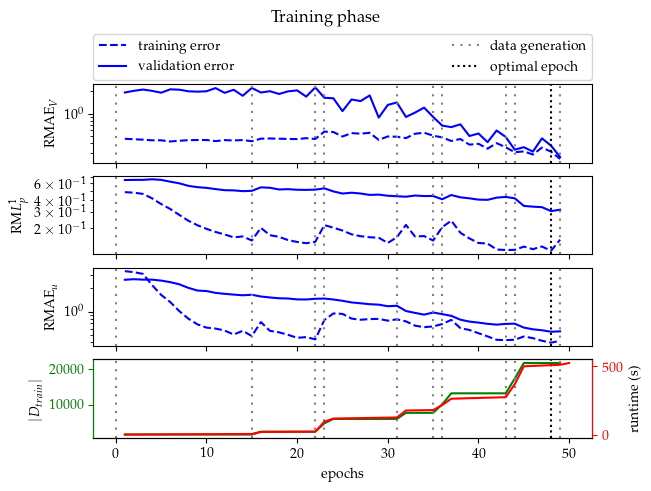

------------------------------------
 Training Statistics
------------------------------------
total training time:           522.755861
total number of training data: 21606

data generation occured at epochs 15, 22, 23, 31, 35, 36, 43, 44 with ratio 1.249556, 1.250000, 1.249948, 1.249917, 1.250000, 1.249951, 1.249962, 1.249986
total epochs: 49, optimal epoch: 48

training errors of optimal model:
value RMAE: 0.310166, grad RML1: 0.115118, ctrl RMAE: 0.393813
validation errors of optimal model:
value RMAE: 0.373655, grad RML1: 0.302878, ctrl RMAE: 0.546405



In [9]:
# plot errors, data set size and runtime in training phase
training.plot_training_phase(save=True, problem_type=problem_type, model_type=model_type, train_type=train_type)

# display training statistics
training.display_stats(save=True, problem_type=problem_type, model_type=model_type, train_type=train_type)

### Testing  model

In [10]:
# choose number of trajectories in test set
num_test_samples = 10

# load optimal model parameters
model = NN.load_model(problem_type, model_type, train_type)

# generate test data using NN warm start
X0_samples = data_generation.sample_X0(problem, num_samples=num_test_samples)
print('------------------------------------\n Test Data Generation\n------------------------------------')
with warnings.catch_warnings():
    warnings.simplefilter('once')
    t_data, X_aug_data, idx_samples, _ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', 
                                                       init_config={'model':model})
data_generation.save_data(t_data, X_aug_data, idx_samples, problem_type, 'test')

# compute test accuracy
test_data = data_generation.OCPDataset(problem_type, 'test')
if training.batch_size == 'full':
    test_dataloader = DataLoader(test_data, batch_size=len(test_data))
else:
    test_dataloader = DataLoader(test_data, batch_size=training.batch_size, shuffle=True)
print('------------------------------------\n Test Statistics\n------------------------------------')
print('test errors of optimal model:')
training.test_errors = np.hstack((training.test_errors, training.validate(test_dataloader, problem, model)))
training.add_test_stats(problem_type=problem_type, model_type=model_type, train_type=train_type)

------------------------------------
 Test Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 10 generating 4094 data points (from 2093 initially guessed points)
solution time:       45.884343 of which 26.716417 solving BVP
solution time per data point: 0.011208

------------------------------------
 Test Statistics
------------------------------------
test errors of optimal model:
value RMAE: 0.428900, grad RML1: 0.342829, ctrl RMAE: 1.170540


### Properties of data sets

In [11]:
# display properties of data sets
print('------------------------------------\n Training Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'train', save=True, model_type=model_type, train_type=train_type)

print('------------------------------------\n Validation Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'val', save=True, model_type=model_type, train_type=train_type)

print('------------------------------------\n Test Data Set\n------------------------------------')
data_generation.add_dataset_stats(problem_type, 'test', save=True, model_type=model_type, train_type=train_type)

------------------------------------
 Training Data Set
------------------------------------
number of trajectories: 42, number of data points: 21606

------------------------------------
 Validation Data Set
------------------------------------
number of trajectories: 5, number of data points: 1738

------------------------------------
 Test Data Set
------------------------------------
number of trajectories: 10, number of data points: 4094



### Simulation of NN, BVP, LQR solutions and uncontrolled system for specific initial condition

In [12]:
# name specific initial condition
init_type = 'sin'

# choose specific initial condition
#initial_condition = OCP.zero
#initial_condition = OCP.quadratic
#initial_condition = OCP.polynomial
initial_condition = OCP.sin
#initial_condition = OCP.quadratic_cos

# option to multiply initial condition with factor (scale or flip sign)
scale_factor = 1.

specific_X0 = scale_factor * initial_condition(problem.Omega_mesh[1:-1]).reshape(-1,1)

# get target
Y = problem.target(problem.Omega_mesh[1:-1]).reshape(-1,1)

# decide on methods for comparison (bilinear control does not allow for LQR)
methods = ['NN', 'LQR', 'BVP', 'unctrl'] 
if problem.ctrl == 'bilin' and 'LQR' in methods:
    methods.remove('LQR')

In [13]:
import NN_evaluation
import LQR
import simulation

# compute closed-loop NN solution
if 'NN' in methods:
    t_NN, X_NN = NN_evaluation.get_trajectory(problem, model, specific_X0)
    V_NN, P_NN, U_NN = NN_evaluation.get_data(model, t_NN, X_NN, get_U=True, problem=problem)

# compute closed-loop LQR solution
if 'LQR' in methods:
    if problem.target == OCP.zero:
        LQ_problem = LQR.LQProblem(problem)
    else:
        LQ_problem = LQR.LQProblemNonzeroTarget(problem)
    t_LQR, X_LQR = LQ_problem.get_trajectory(specific_X0)
    V_LQR, P_LQR, U_LQR = LQ_problem.get_data(t_LQR, X_LQR)
    
# compute open-loop BVP solution
if 'BVP' in methods:
    print('------------------------------------\n Specific Example Data Generation\n------------------------------------') 
    solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
    t_BVP, X_aug_BVP, _, X_aug_funs = BVP.solve_BVP(problem, specific_X0, initialization='NN_warm_start',
                                            init_config={'model':model}, solver_config=solver_config)
    X_BVP, V_BVP, P_BVP, U_BVP = data_generation.split_data(X_aug_BVP, get_U=True, problem=problem)
    
# compute uncontrolled dynamics 
if 'unctrl' in methods:
    ctrl = problem.ctrl
    problem.ctrl = None  
    print('--- Uncontrolled System ---')
    init_config = {'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}
    solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}
    t_unctrl, X_aug_unctrl, _, _ = BVP.solve_BVP(problem, specific_X0, initialization='time_marching', 
                                                 init_config=init_config, solver_config=solver_config)
    X_unctrl, V_unctrl, P_unctrl, U_unctrl = data_generation.split_data(X_aug_unctrl, get_U=True, problem=problem)
    if not len(t_unctrl):
        methods.remove('unctrl')
    problem.ctrl = ctrl

------------------------------------
 Specific Example Data Generation
------------------------------------
number of fails:     0
fail time:           0.000000

number of solutions: 1 generating 221 data points (from 203 initially guessed points)
solution time:       3.767678 of which 1.855871 solving BVP
solution time per data point: 0.017048

--- Uncontrolled System ---


/home/eg/Desktop/Masterarbeit/programs/OCP.py:200: RuntimeWarning: overflow encountered in multiply
  dRdx = 2*self.b*P*X
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:309: RuntimeWarning: invalid value encountered in subtract
  0.125 * h * (f[:, 1:] - f[:, :-1]))
/home/eg/Desktop/Masterarbeit/programs/OCP.py:120: RuntimeWarning: overflow encountered in square
  R = self.b*X**2
/home/eg/Desktop/Masterarbeit/programs/OCP.py:210: RuntimeWarning: invalid value encountered in add
  return 2*self.alpha*self.mesh_size * (X-Y) + self.Q.T @ P + dRdx + dSdx
/home/eg/Desktop/Masterarbeit/programs/OCP.py:153: RuntimeWarning: overflow encountered in square
  return self.alpha*self.mesh_size*np.sum((X-Y)**2, axis=0, keepdims=True)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:312: RuntimeWarning: overflow encountered in multiply
  4 * f_middle)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:311: RuntimeWarning: invalid value 

number of fails:     1
fail time:           8.620930

number of solutions: 0 generating 0 data points (from 0 initially guessed points)
solution time:       0.000000 of which 0.000000 solving BVP
solution time per data point: nan    



/home/eg/Desktop/Masterarbeit/programs/BVP.py:115: RuntimeWarning: A singular Jacobian encountered when solving the collocation system.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/BVP.py:198: RuntimeWarning: invalid value encountered in double_scalars
  print(f'solution time per data point: {np.sum(solution_times)/len(t_data):<7f}\n')


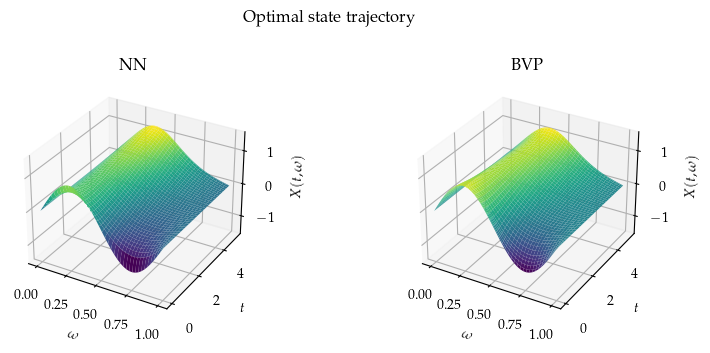

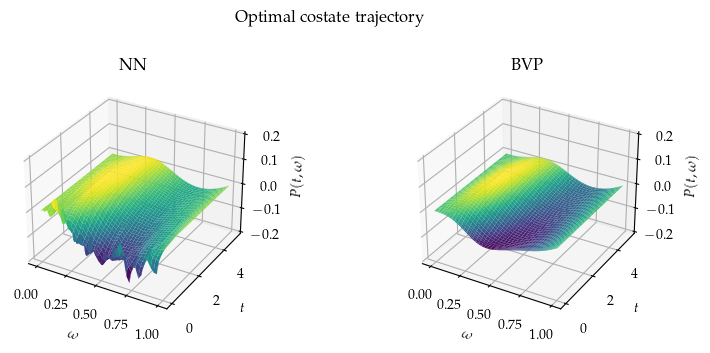

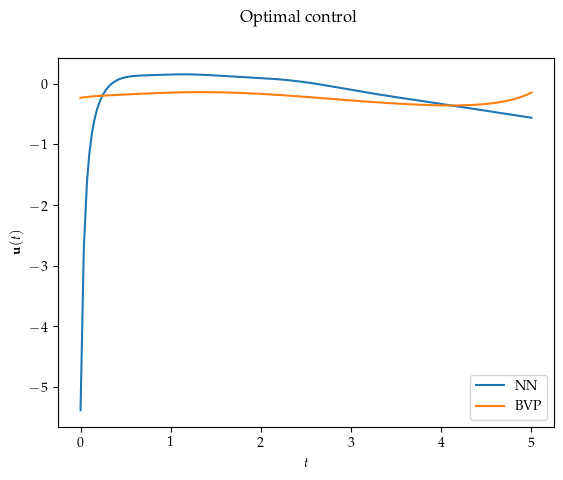

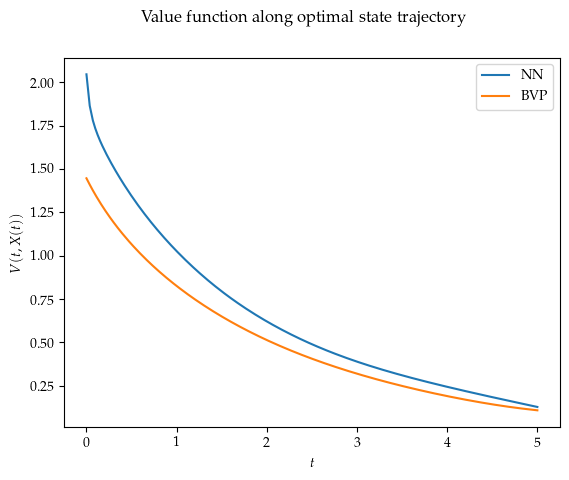

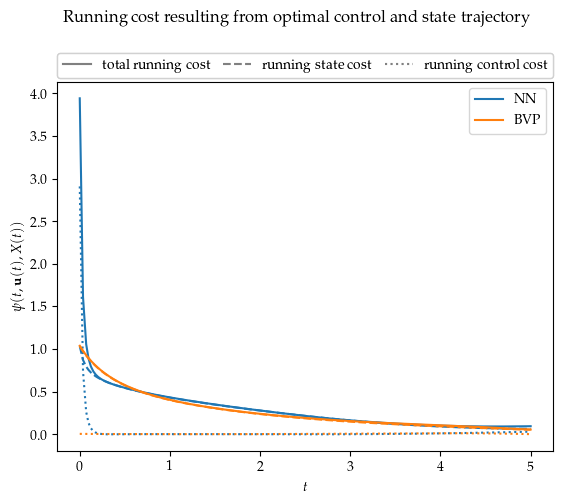

------------------------------------
 Costs of NN Solution
------------------------------------
running state cost:   1.341796
running control cost: 0.123223
total running cost:   1.465019
final cost:           0.128236
total cost:           1.593255

------------------------------------
 Costs of BVP Solution
------------------------------------
running state cost:   1.307491
running control cost: 0.029851
total running cost:   1.337343
final cost:           0.108851
total cost:           1.446194



In [14]:
# create directory for saving results
directory = simulation.get_directory(problem_type, model_type, train_type, init_type)

# plot optimal state trajectory
fig = plt.figure()
fig.suptitle('Optimal state trajectory', y=0.9)
axs = []
for num, method in enumerate(methods):                         
    axs.append(fig.add_subplot(1, len(methods), num + 1, projection='3d'))
    simulation.plot_X(eval('t_' + method), problem.Omega_mesh, eval('X_' + method), ax=axs[num])
    axs[num].set_title(method)
    axs[num].set_zlim(-1.5,1.5)
plt.subplots_adjust(left=0., bottom=0., right=1., top=1., wspace=0.6, hspace=0.0)
plt.savefig(directory + '/state.png', bbox_inches='tight')
plt.show()

# plot optimal costate trajectory
fig = plt.figure()
fig.suptitle('Optimal costate trajectory', y=0.9)
axs = []
for num, method in enumerate(methods):                         
    axs.append(fig.add_subplot(1, len(methods), num + 1, projection='3d'))
    simulation.plot_P(eval('t_' + method), problem.Omega_mesh, eval('P_' + method), ax=axs[num])
    axs[num].set_title(method)
    axs[num].set_zlim(-0.2,0.2)
plt.subplots_adjust(left=0., bottom=0., right=1., top=1., wspace=0.6, hspace=0.0)
plt.savefig(directory + '/costate.png', bbox_inches='tight')
plt.show()

# plot optimal control
fig = plt.figure()
fig.suptitle('Optimal control')
for method in methods:                         
    simulation.plot_U(eval('t_' + method), eval('U_' + method), label=method)
#plt.ylim(bottom=-5)
plt.legend()
plt.savefig(directory + '/control.png')
plt.show()

# plot value function along optimal state trajectory 
fig = plt.figure()
fig.suptitle('Value function along optimal state trajectory')
for method in methods:                         
    simulation.plot_V(eval('t_' + method), eval('V_' + method), label=method)
#plt.ylim(top=2.5)
plt.legend()
plt.savefig(directory + '/value_function.png')
plt.show()

# plot running cost resulting from optimal control and state trajectory 
fig = plt.figure()
fig.suptitle('Running cost resulting from optimal control and state trajectory', y=1.03)
for num, method in enumerate(methods):                         
    simulation.plot_running_cost(problem, eval('t_' + method), eval('U_' + method), eval('X_' + method), Y, 
                                 color='C' + str(num), label=method)
#plt.ylim(-1,5)
legend = plt.legend()
solid_line, = plt.plot([0],linestyle='-', color='gray')
dashed_line, = plt.plot([0],linestyle='--', color='gray')
dotted_line, = plt.plot([0],linestyle=':', color='gray')
legend_lines = plt.legend([solid_line, dashed_line, dotted_line], ['total running cost', 'running state cost', 'running control cost'], 
                          bbox_to_anchor=(0, 1.01, 1, 0.2), loc='lower left', mode='expand', borderaxespad=0, ncol=3)
plt.gca().add_artist(legend)
plt.gca().add_artist(legend_lines)
plt.savefig(directory + '/running_cost.png')
plt.show()

# display costs
for num, method in enumerate(methods): 
    append = False if num == 0 else True
    simulation.display_costs(problem, eval('t_' + method), eval('U_' + method), eval('X_' + method), Y, 
                             method=method, save=True, append=append, 
                             problem_type=problem_type, model_type=model_type, train_type=train_type, init_type=init_type)

### Simulation with noise

In [15]:
# choose mean and variance of Gaussian noise, start and end time with scaling factor of shock noise
#stoch_noise = [0., 0.]
stoch_noise = [0., 0.5]
#det_noise = [2., 3., 0.]
det_noise = [2., 3., 2.]

# decide on methods for comparison (bilinear control does not allow for LQR)
noisy_methods = ['NN', 'LQR', 'BVP']
if problem.ctrl == 'bilin' and 'LQR' in noisy_methods:
    noisy_methods.remove('LQR')

# compute closed-loop NN solution
if 'NN' in noisy_methods:
    t_noisy_NN, X_noisy_NN = NN_evaluation.get_trajectory(problem, model, specific_X0, 
                                                          stoch_noise=stoch_noise, det_noise=det_noise)
    _, _, U_noisy_NN = NN_evaluation.get_data(model, t_noisy_NN, X_noisy_NN, get_U=True, problem=problem)

# compute closed-loop LQR solution
if 'LQR' in noisy_methods:
    t_noisy_LQR, X_noisy_LQR = LQ_problem.get_trajectory(specific_X0, stoch_noise=stoch_noise, det_noise=det_noise)
    _, _, U_noisy_LQR = LQ_problem.get_data(t_noisy_LQR, X_noisy_LQR)
    
# compute open-loop BVP solution
if 'BVP' in noisy_methods:
    assert 'BVP' in methods 
    t_noisy_BVP, X_noisy_BVP = BVP.get_trajectory(problem, specific_X0, X_aug_funs[0], 
                                                  stoch_noise=stoch_noise, det_noise=det_noise)
    _, _, U_noisy_BVP = BVP.get_data(problem, t_noisy_BVP, X_aug_funs[0])

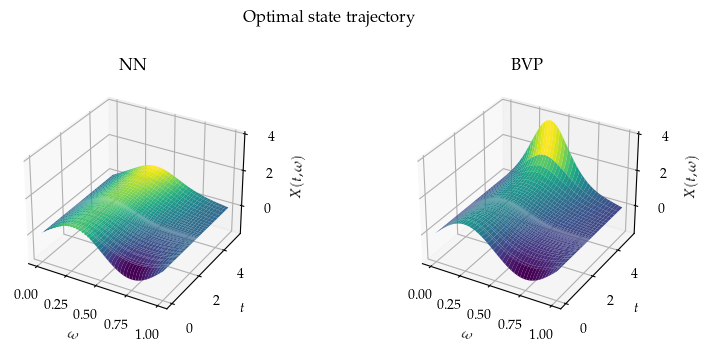

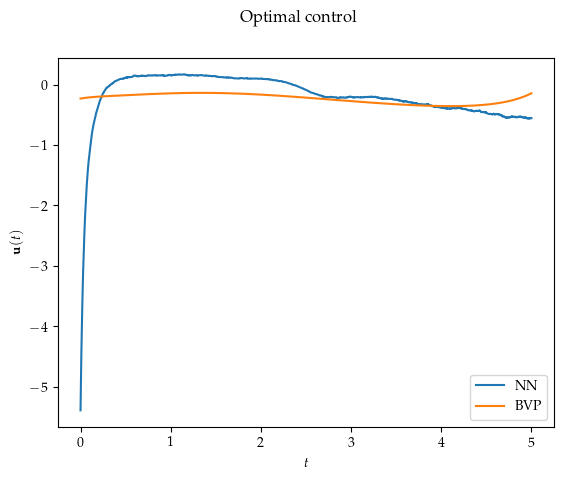

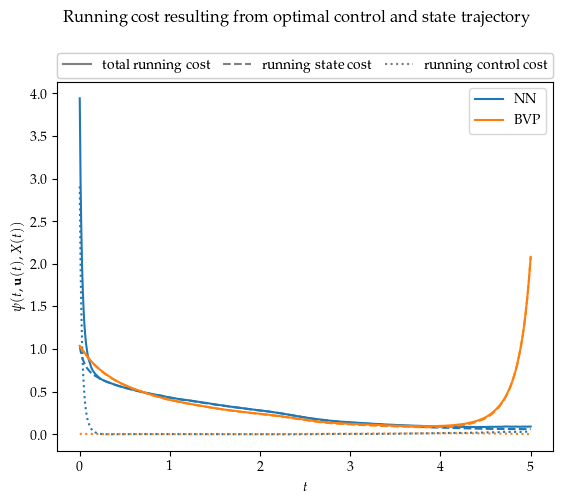

------------------------------------
 Costs of noisy NN Solution
------------------------------------
running state cost:   1.301592
running control cost: 0.116667
total running cost:   1.418259
final cost:           0.120898
total cost:           1.539157

------------------------------------
 Costs of noisy BVP Solution
------------------------------------
running state cost:   1.590719
running control cost: 0.029852
total running cost:   1.620571
final cost:           4.158394
total cost:           5.778965



In [16]:
# plot optimal state trajectory
fig = plt.figure()
fig.suptitle('Optimal state trajectory', y=0.9)
axs = []
for num, noisy_method in enumerate(noisy_methods):                         
    axs.append(fig.add_subplot(1, len(noisy_methods), num + 1, projection='3d'))
    simulation.plot_X(eval('t_noisy_' + noisy_method), problem.Omega_mesh, eval('X_noisy_' + noisy_method), ax=axs[num])
    axs[num].set_title(noisy_method)
    axs[num].set_zlim(-1.5,4)
plt.subplots_adjust(left=0., bottom=0., right=1., top=1., wspace=0.6, hspace=0.0)
plt.savefig(directory + '/noisy_state.png', bbox_inches='tight')
plt.show()

# plot optimal control
fig = plt.figure()
fig.suptitle('Optimal control')
for noisy_method in noisy_methods:                         
    simulation.plot_U(eval('t_noisy_' + noisy_method), eval('U_noisy_' + noisy_method), label=noisy_method)
#plt.ylim(bottom=-5)
plt.legend()
plt.savefig(directory + '/noisy_control.png')
plt.show()

# plot running cost resulting from optimal control and state trajectory 
fig = plt.figure()
fig.suptitle('Running cost resulting from optimal control and state trajectory', y=1.03)
for num, noisy_method in enumerate(noisy_methods):                         
    simulation.plot_running_cost(problem, eval('t_noisy_' + noisy_method), eval('U_noisy_' + noisy_method), 
                                 eval('X_noisy_' + noisy_method), Y, color='C' + str(num), label=noisy_method)
#plt.ylim(-1,5)
legend = plt.legend()
solid_line, = plt.plot([0],linestyle='-', color='gray')
dashed_line, = plt.plot([0],linestyle='--', color='gray')
dotted_line, = plt.plot([0],linestyle=':', color='gray')
legend_lines = plt.legend([solid_line, dashed_line, dotted_line], ['total running cost', 'running state cost', 'running control cost'], 
                          bbox_to_anchor=(0, 1.01, 1, 0.2), loc='lower left', mode='expand', borderaxespad=0, ncol=3)
plt.gca().add_artist(legend)
plt.gca().add_artist(legend_lines)
plt.savefig(directory + '/noisy_running_cost.png')
plt.show()

# display costs
for noisy_method in noisy_methods: 
    simulation.display_costs(problem, eval('t_noisy_' + noisy_method), eval('U_noisy_' + noisy_method), 
                             eval('X_noisy_' + noisy_method), Y, method='noisy ' + noisy_method, save=True, append=True,
                             problem_type=problem_type, model_type=model_type, train_type=train_type, init_type=init_type)

### Testing BVP initialization for data generation

In [17]:
# sample initial conditions
X0_samples = data_generation.sample_X0(problem, num_samples=10)
solver_config = {'max_nodes':5000, 'tol':1e-5, 'replace_sample':False}

# test simple initialization
print('------------------------------------\n Simple Initialization\n------------------------------------')
_ = BVP.solve_BVP(problem, X0_samples, solver_config=solver_config)
#print('\n--- Increased time steps ---')
#_ = BVP.solve_BVP(problem, X0_samples, init_config={'timesteps':100}, solver_config=solver_config)

# test time-marching
print('------------------------------------\n Time-Marching\n------------------------------------')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', solver_config=solver_config)
print('\n--- Adaptive time sequence ---')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                  init_config={'timeseq':np.array([0, 1e-03, 1e-02, .1, .125, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.])}, 
                  solver_config=solver_config)
print('\n--- Equidistant time sequences with increased time steps ---')
_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
                  init_config={'timeseq':30}, solver_config=solver_config)
#print('\n--- Equidistant time sequences with decreased time steps ---')
#_ = BVP.solve_BVP(problem, X0_samples, initialization='time_marching', 
#                  init_config={'timeseq':5}, solver_config=solver_config)

# test NN warm start
print('------------------------------------\n NN Warm Start\n------------------------------------') 
_ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', 
                  init_config={'model':model}, solver_config=solver_config)

# test NN warm start with partially trained models
for partial_train_time in partial_train_times[:-1]:
    partial_train_type = train_type + 'PartialTrain' + str(partial_train_time)
    directory = NN.get_directory(problem_type, model_type, partial_train_type, make=False)
    if os.path.exists(directory):
        print(f'\n--- Partially trained model after time {partial_train_time} ---')
        partial_train_model = NN.load_model(problem_type, model_type, partial_train_type)
        _ = BVP.solve_BVP(problem, X0_samples, initialization='NN_warm_start', init_config={'model':partial_train_model}, solver_config=solver_config)

------------------------------------
 Simple Initialization
------------------------------------


/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/Desktop/Masterarbeit/programs/OCP.py:130: RuntimeWarning: overflow encountered in multiply
  S = self.c*U*X
/home/eg/Desktop/Masterarbeit/programs/OCP.py:208: RuntimeWarning: overflow encountered in multiply
  dSdx = self.c*U*P
/home/eg/Desktop/Masterarbeit/programs/OCP.py:157: RuntimeWarning: overflow encountered in square
  return self.beta*U**2
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:312: RuntimeWarning: overflow encountered in multiply
  4 * f_middle)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:40: RuntimeWarning: invalid value encountered in subtract
  df_dy[:, i, :] = (f_new - f0) / hi
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:566: RuntimeWarning: invalid value encountered in true_divide
  r_middle /= 1 + np.abs(f_middle)
/home/eg

number of fails:     6
fail time:           100.684219

number of solutions: 4 generating 1361 data points (from 120 initially guessed points)
solution time:       11.863714 of which 11.863216 solving BVP
solution time per data point: 0.008717

------------------------------------
 Time-Marching
------------------------------------


/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:594: RuntimeWarning: overflow encountered in true_divide
  c[1] = (slope - yp[:, :-1]) / h - t
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:594: RuntimeWarning: invalid value encountered in subtract
  c[1] = (slope - yp[:, :-1]) / h - t
/home/eg/Desktop/Masterarbeit/programs/BVP.py:115: RuntimeWarning: A singular Jacobian encountered when solving the collocation system.
  warnings.warn(sol.message, RuntimeWarning)
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:592: RuntimeWarning: invalid value encountered in subtract
  t = (yp[:, :-1] + yp[:, 1:] - 2 * slope) / h
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:592: RuntimeWarning: overflow encountered in true_divide
  t = (yp[:, :-1] + yp[:, 1:] - 2 * slope) / h
/home/eg/anaconda3/lib/python3.9/site-packages/scipy/integrate/_bvp.py:593: RuntimeWarning: overflow encountered in true_divide
  c[0

number of fails:     9
fail time:           26.186772

number of solutions: 1 generating 333 data points (from 304 initially guessed points)
solution time:       14.383977 of which 3.265884 solving BVP
solution time per data point: 0.043195


--- Adaptive time sequence ---


/home/eg/Desktop/Masterarbeit/programs/BVP.py:115: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)


number of fails:     1
fail time:           47.855461

number of solutions: 9 generating 3065 data points (from 2705 initially guessed points)
solution time:       134.238236 of which 30.300986 solving BVP
solution time per data point: 0.043797


--- Equidistant time sequences with increased time steps ---
number of fails:     1
fail time:           61.282195

number of solutions: 9 generating 4019 data points (from 3806 initially guessed points)
solution time:       508.137104 of which 34.105201 solving BVP
solution time per data point: 0.126434

------------------------------------
 NN Warm Start
------------------------------------


/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)


number of fails:     1
fail time:           21.174557

number of solutions: 9 generating 3976 data points (from 1881 initially guessed points)
solution time:       42.705335 of which 25.681212 solving BVP
solution time per data point: 0.010741


--- Partially trained model after time 5 ---


/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)


number of fails:     1
fail time:           20.495175

number of solutions: 9 generating 4817 data points (from 1882 initially guessed points)
solution time:       49.959029 of which 32.950383 solving BVP
solution time per data point: 0.010371


--- Partially trained model after time 100 ---


/home/eg/Desktop/Masterarbeit/programs/BVP.py:156: RuntimeWarning: The maximum number of mesh nodes is exceeded.
  warnings.warn(sol.message, RuntimeWarning)


number of fails:     1
fail time:           20.500538

number of solutions: 9 generating 4654 data points (from 1882 initially guessed points)
solution time:       48.930282 of which 31.725232 solving BVP
solution time per data point: 0.010514

